# Creating a System

## Conventional methods

Systems are defined by a recycle stream (i.e. a tear stream; if any), and a path of unit operations and nested systems. A System object takes care of solving recycle streams by iteratively running its path of units and subsystems until the recycle converges to steady state. Systems can be manually created or automatically generated via the flowsheet or by context management.

### Manually generated

Manually creating a system is **not recommended** as it requires an exponential amount of time and effort for an individual to layout an accurate path. Here we create a trivial system manually as a simple exercise:

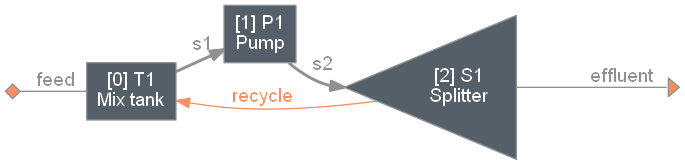

In [1]:
import biosteam as bst
from warnings import filterwarnings; filterwarnings('ignore')
bst.settings.set_thermo(['Water'])
feed = bst.Stream('feed', Water=100)
recycle = bst.Stream('recycle')
effluent = bst.Stream('effluent')
T1 = bst.MixTank('T1', ins=[feed, recycle])
P1 = bst.Pump('P1', T1-0)
S1 = bst.Splitter('S1', P1-0, [effluent, recycle], split=0.5)
manual_sys = bst.System('manual_sys', path=[T1, P1, S1], recycle=recycle)
manual_sys.simulate()
manual_sys.diagram(
    kind='cluster', # Cluster diagrams highlight recycle streams and nested systems.
    number=True, # This numbers each unit according to their path simulation order
) 

In [2]:
manual_sys.show()

System: manual_sys
Highest convergence error among components in recycle
stream S1-1 after 3 loops:
- flow rate   0.00e+00 kmol/hr (0%)
- temperature 0.00e+00 K (0%)
ins...
[0] feed
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  100
outs...
[0] effluent
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  100


Note that the inlets and outlets to a system are inherently connected to the unit operations within the system, but we can still connect systems just like unit operations, as depicted future examples.

### Autogenerated from the flowsheet

The **recommended** way of creating systems is to use the flowsheet. Here we expand on the existing process and create a new system using the flowsheet:

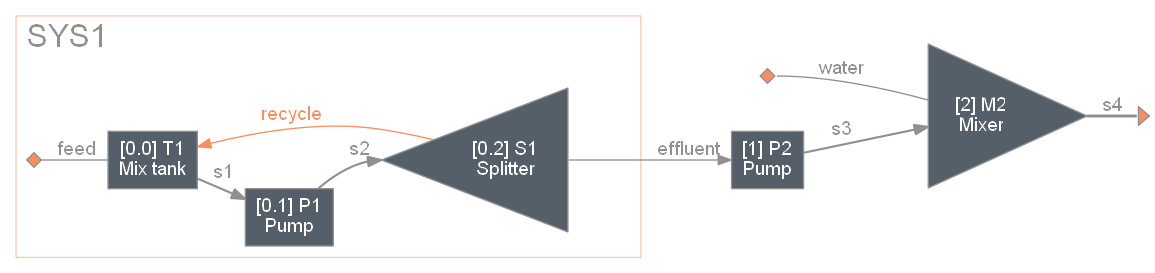

In [3]:
water = bst.Stream('water', Water=10)
P2 = bst.Pump('P2', manual_sys-0) # -pipe- notation equivalent to manual_sys.outs[0]
M2 = bst.Mixer('M2', [P2-0, water])
flowsheet_sys = bst.main_flowsheet.create_system('flowsheet_sys')
flowsheet_sys.simulate()

# Units in subsystems are numbered with after a "." to represent 
# the subsystem depth (checkout SYS1 in the diagram)
flowsheet_sys.diagram(kind='cluster', number=True)

In [4]:
flowsheet_sys.show()

System: flowsheet_sys
ins...
[0] feed
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  100
[1] water
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  10
outs...
[0] s4
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  110


### Autogenerated by context management

System objects' context management feature allows for creating systems of only the units created within the given context:

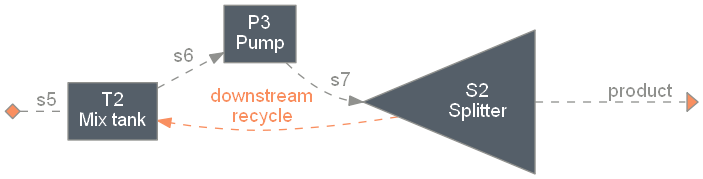

In [5]:
downstream_recycle = bst.Stream('downstream_recycle')
product = bst.Stream('product')
with bst.System('context_sys') as context_sys:
    T2 = bst.MixTank('T2', ins=['', downstream_recycle])
    P3 = bst.Pump('P3', T2-0)
    S2 = bst.Splitter('S2', P3-0, [product, downstream_recycle], split=0.5)
# The feed is empty, no need to run system (yet)
context_sys.diagram('cluster')

In [6]:
context_sys.show()

System: context_sys
ins...
[0] s5
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
outs...
[0] product
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0


Let's connect two systems together and create a new system from the flowsheet:

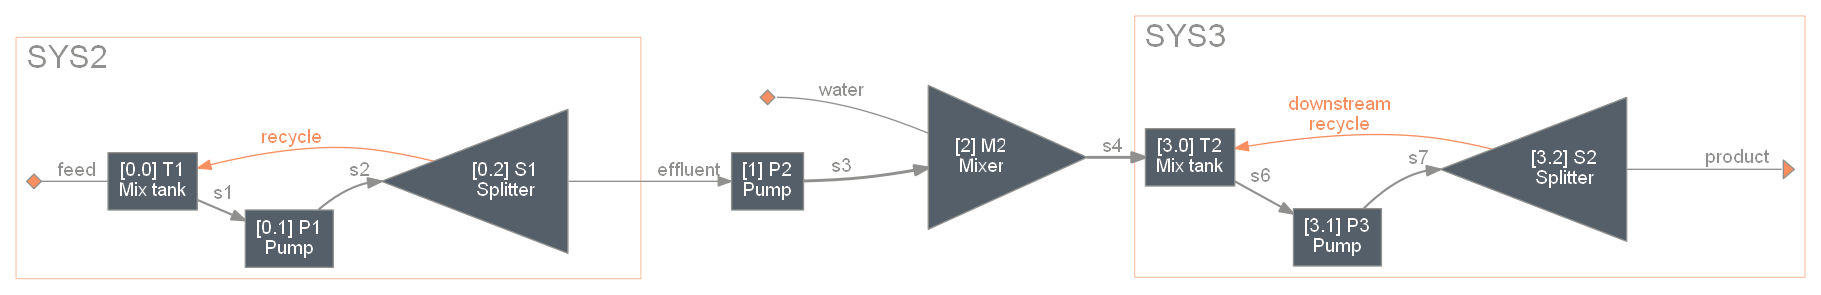

In [7]:
# -pipe- notation equivalent to context_sys.ins[:] = [flowsheet_sys.outs[0]]
flowsheet_sys-0-context_sys 
complete_sys = bst.main_flowsheet.create_system('complete_sys')
complete_sys.simulate()
complete_sys.diagram('cluster', number=True)

In [8]:
complete_sys.show()

System: complete_sys
ins...
[0] feed
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  100
[1] water
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  10
outs...
[0] product
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  110


## Drop-in systems

### A simple example

When a system is created by a function, it's called a drop-in system. Here, we create a sugarcane to ethanol production system without facilities (e.g., cooling tower, boiler) by using drop-in systems:

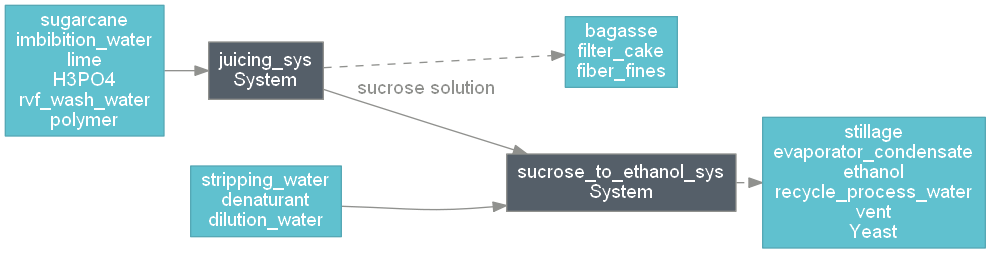

In [9]:
from biorefineries.sugarcane import chemicals
from biosteam import Stream, System, settings, main_flowsheet
from biorefineries.sugarcane import (
    create_juicing_system_with_fiber_screener as create_juicing_system,
    create_sucrose_to_ethanol_system 
)

main_flowsheet.clear() # Remove previous unit operations to prevent ID-conflict warnings
settings.set_thermo(chemicals)
denaturant = Stream('denaturant',
                    Octane=230.69,
                    units='kg/hr',
                    price=0.756)
sucrose_solution = Stream('sucrose_solution')

juicing_sys = create_juicing_system(
    ID='juicing_sys', # ID of system
    outs=[sucrose_solution], # Place sucrose_solution at the 0th outlet (all other streams are defaulted)
) 
sucrose_to_ethanol_sys = create_sucrose_to_ethanol_system(ins=[sucrose_solution, denaturant]) 

# Here are a couple of other ways to connect systems:
#   Manually:
#   >>> sucrose_to_ethanol_sys.ins[0] = juicing_sys.outs[0]
#   With -pipe- notation:
#   >>> juicing_sys-0-0-sucrose_to_ethanol_sys 

# Manually create a new system to view a diagram of systems
sugarcane_to_ethanol_sys = System('sugarcane_to_ethanol_sys', 
                                  path=[juicing_sys, sucrose_to_ethanol_sys])
sugarcane_to_ethanol_sys.simulate() # Simulate before showing results
sugarcane_to_ethanol_sys.diagram(kind='surface')

In [10]:
sugarcane_to_ethanol_sys.show(data=False)

System: sugarcane_to_ethanol_sys
ins...
[0] imbibition_water
[1] sugarcane
[2] rvf_wash_water
[3] H3PO4
[4] lime
[5] polymer
[6] stripping_water
[7] dilution_water
[8] denaturant
outs...
[0] filter_cake
[1] fiber_fines
[2] bagasse
[3] vent
[4] evaporator_condensate
[5] stillage
[6] Yeast
[7] recycle_process_water
[8] ethanol


The number of inlets and outlets are rather large. It may be helpful to specify what inlets and outlets do we want to expose:

In [11]:
s = main_flowsheet.stream
sugarcane_to_ethanol_sys.load_inlet_ports([s.sugarcane], names={'feedstock': 0})
sugarcane_to_ethanol_sys.load_outlet_ports([s.ethanol, s.bagasse], names={'product': 0})
sugarcane_to_ethanol_sys.show(data=False)

System: sugarcane_to_ethanol_sys
ins...
[0] sugarcane
outs...
[0] ethanol
[1] bagasse


The ethanol product is now the 0th stream

In [12]:
sugarcane_to_ethanol_sys.outs[0].show()

Stream: ethanol from <StorageTank: T304>
 phase: 'l', T: 339.28 K, P: 101325 Pa
 flow (kmol/hr): Water    10.4
                 Ethanol  491
                 Octane   4.39


We can also use the names we gave earlier for getting and setting streams:

In [13]:
print([sugarcane_to_ethanol_sys.get_inlet('feedstock'),
       sugarcane_to_ethanol_sys.get_outlet('product')])
# You can also use <System>.set_inlet(name, stream)

[<Stream: sugarcane>, <Stream: ethanol>]


### System factories

Both `create_juicing_system` and `create_sucrose_to_ethanol_system` are [SystemFactory](../API/process_tools/SystemFactory.txt) objects, which accept the system `ID`, `ins`, and `outs` (similar to unit operations) and return a new system. Let's first have a look at some of the system factories in the [biorefineries.sugarcane](https://github.com/BioSTEAMDevelopmentGroup/Bioindustrial-Park/tree/master/BioSTEAM%202.x.x/biorefineries/sugarcane) library:  

In [14]:
create_juicing_system.show()
print()
create_sucrose_to_ethanol_system.show() 

SystemFactory(
    f=<create_juicing_system_with_fiber_screener(ins, outs, pellet_bagasse=None)>,
    ID='juicing_sys',
    ins=[dict(Water=0.7,
              Glucose=0.01208,
              Sucrose=0.1369,
              Ash=0.006,
              Cellulose=0.06115,
              Hemicellulose=0.03608,
              Lignin=0.03276,
              Solids=0.015,
              ID='sugarcane',
              units='kg/hr',
              price=0.03455,
              total_flow=333334.2),
         dict(H3PO4=74.23,
              Water=13.1,
              ID='H3PO4',
              units='kg/hr',
              price=0),
         dict(CaO=333.0,
              Water=2200.0,
              ID='lime',
              units='kg/hr',
              price=0.077),
         dict(Flocculant=0.83,
              ID='polymer',
              units='kg/hr',
              price=0)],
    outs=[dict(Glucose=3802,
               Sucrose=43090.0,
               Water=259000.0,
               H3PO4=83.33,
               ID

[SystemFactory](../API/process_tools/SystemFactory.txt) objects are composed of a function `f` which creates the unit operations, a predefined system `ID`, and `ins` and `outs` dictionaries that serve as keyword arguments to initialize the system's default inlets and outlets. 

The signature of a SystemFactory is `f(ID=None, ins=None, outs=None, mockup=False, area=None, udct=None, ...)`. The additional parameters (i.e. mockup, area, and udct) will be discussed in the next section.

### Mock systems

When creating a biorefinery, we may not be interested in all the subsystems we created with SystemFactory objects. We can save a few milliseconds in computational time (per system) by using mock systems:

In [15]:
main_flowsheet.clear() # Remove previous unit operations to prevent ID-conflict warnings
juicing_sys = create_juicing_system(
    outs=[sucrose_solution],
    mockup=True
) 
sucrose_to_ethanol_sys = create_sucrose_to_ethanol_system(
    ins=[sucrose_solution, denaturant],
    mockup=True
) 
# Note that mock systems don't have anything other than `ins`, `outs`, and `units` 
juicing_sys.show()
sucrose_to_ethanol_sys.show()

MockSystem(
    ins=[0-U201, 1-T203, 0-T204, 1-T206],
    outs=[S202-0, U202-0, S202-1],
    units=[U201, U202, M201, S201, T202,
           H201, T203, P201, T204, T205,
           P202, M202, H202, T206, C201,
           C202, P203, S202]
)
MockSystem(
    ins=[0-F301, 0-T303],
    outs=[T304-0, H302-1, P303-0, F301-1],
    units=[F301, P306, M301, H301, R301,
           T301, C301, S302, D301, M302,
           P301, D302, P302, H302, M303,
           D303, P303, H303, U301, H304,
           T302, P304, T303, P305, M304,
           T304]
)


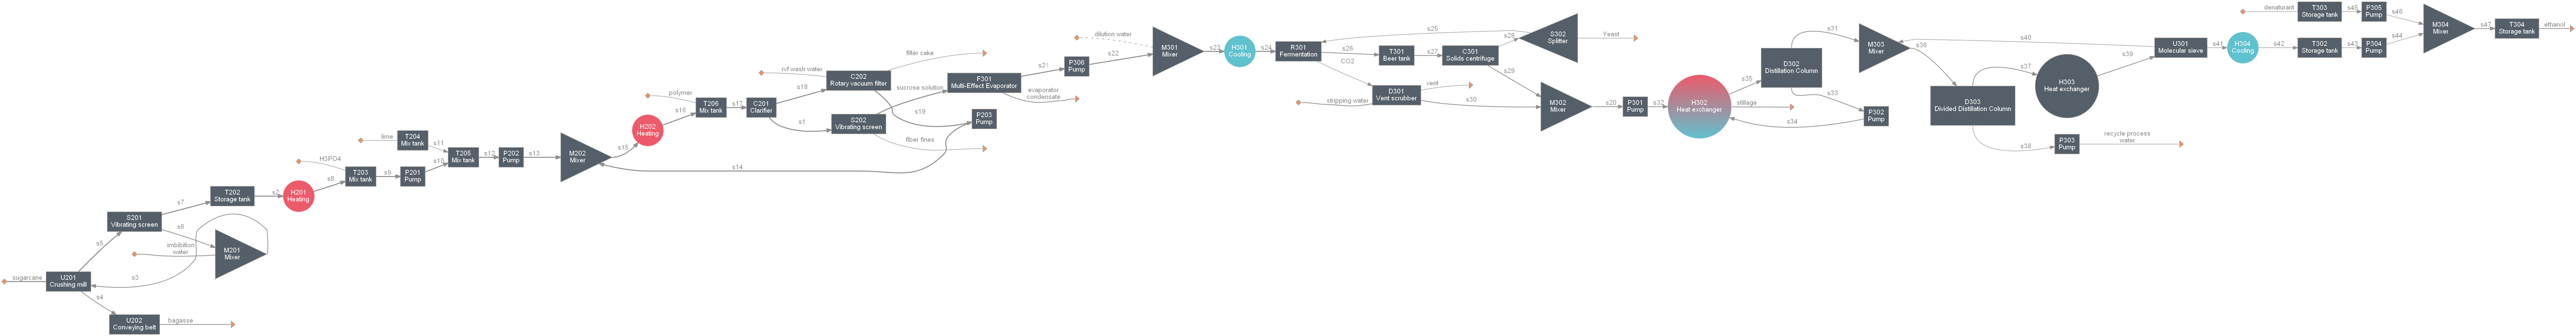

In [16]:
# We can create the system using the flowsheet
sugarcane_to_ethanol_sys = main_flowsheet.create_system('sugarcane_to_ethanol_sys')
sugarcane_to_ethanol_sys.simulate()
sugarcane_to_ethanol_sys.diagram()

In [17]:
sucrose_to_ethanol_sys.outs[0].show()

Stream: ethanol from <StorageTank: T304>
 phase: 'l', T: 339.28 K, P: 101325 Pa
 flow (kmol/hr): Water    10.4
                 Ethanol  491
                 Octane   4.39


### Using the area naming convention

The area naming convention follows {letter}{area + number} where the letter depends on
the unit operation as follows:

* C: Centrifuge
* D: Distillation column
* E: Evaporator
* F: Flash tank
* H: Heat exchange
* K: Compressor
* M: Mixer
* P: Pump (including conveying belt)
* R: Reactor
* S: Splitter (including solid/liquid separator)
* T: Tank or bin for storage
* U: Other units
* V: Valve
* J: Junction, not a physical unit (serves to adjust streams)
* PS: Process specificiation, not a physical unit (serves to adjust streams)

For example, the first mixer in area 100 would be named M101. When calling a SystemFactory object, we can pass the `area` to name unit operations according to the area convention. In the following example, we name all unit operations in the juicing system under area 300:

In [18]:
main_flowsheet.clear() # Remove previous unit operations
juicing_sys = create_juicing_system(area=300, mockup=True) 
juicing_sys.show()

MockSystem(
    ins=[0-U301, 1-T302, 0-T303, 1-T305],
    outs=[U306-0, U302-0, U306-1],
    units=[U301, U302, M301, U303, T301,
           H301, T302, P301, T303, T304,
           P302, M302, H302, T305, U304,
           U305, P303, U306]
)


To access unit operations by their default ID (as originally defined in SystemFactory code), you can request a unit dictionary by passing `udct`=True:

In [19]:
main_flowsheet.clear() # Remove previous unit operations
# When udct is True, both the system and the unit dictionary are returned 
juicing_sys, udct = create_juicing_system(mockup=True, area=300, udct=True) 
unit = udct['U201']
print(repr(unit)) # Originally, this unit was named U201

<CrushingMill: U301>


### Creating system factories 

Create a SystemFactory object for mixing in gasoline to ethanol: 

In [20]:
from biosteam import System, SystemFactory

@SystemFactory(
    ID='denature_ethanol_sys',
    ins=[dict(ID='dehydrated_ethanol',
              Water=0.001,
              Ethanol=0.999,
              total_flow=9.05e7,
              units='kg/hr'),
         dict(ID='denaturant',
              price=0.756)],
    outs=[dict(ID='denatured_ethanol',
               price=0.789)]
)
def create_denature_ethanol_sys(ins, outs):
    # ins and outs will be stream objects
    dehydrated_ethanol, denaturant = ins
    denatured_ethanol, = outs
    M1 = bst.Mixer('M1', ins=(dehydrated_ethanol, denaturant))
    S1 = bst.StorageTank('S1', ins=M1-0, outs=denatured_ethanol)

    # Create the specification function.
    @M1.add_specification
    def adjust_denaturant_flow():
        denaturant_over_ethanol_flow = 0.02 / 0.98 # A mass ratio
        denaturant.imass['Octane'] = denaturant_over_ethanol_flow * dehydrated_ethanol.F_mass
        M1.run() # Run mass and energy balance
        
# The system factory builds a system from units created by the function
create_denature_ethanol_sys.show()

SystemFactory(
    f=<create_denature_ethanol_sys(ins, outs)>,
    ID='denature_ethanol_sys',
    ins=[dict(ID='dehydrated_ethanol',
              Water=0.001,
              Ethanol=0.999,
              total_flow=90500000.0,
              units='kg/hr'),
         dict(ID='denaturant',
              price=0.756)],
    outs=[dict(ID='denatured_ethanol',
               price=0.789)]
)


Create the system and simulate:

In [21]:
main_flowsheet.clear() # Remove previous unit operations
denature_ethanol_sys = create_denature_ethanol_sys()
denature_ethanol_sys.simulate()
denature_ethanol_sys.show('cwt')

System: denature_ethanol_sys
ins...
[0] dehydrated_ethanol
    phase: 'l', T: 298.15 K, P: 101325 Pa
    composition: Water    0.001
                 Ethanol  0.999
                 -------  9.05e+07 kg/hr
[1] denaturant
    phase: 'l', T: 298.15 K, P: 101325 Pa
    composition: Octane  1
                 ------  1.85e+06 kg/hr
outs...
[0] denatured_ethanol
    phase: 'l', T: 298.15 K, P: 101325 Pa
    composition: Water    0.00098
                 Ethanol  0.979
                 Octane   0.02
                 -------  9.23e+07 kg/hr


Biorefinery systems can be created by connecting smaller systems, allowing us to create alternative configurations with ease. The [biorefineries](https://github.com/BioSTEAMDevelopmentGroup/Bioindustrial-Park) library has yet to fully implement SystemFactory objects across all functions that create systems, but that is the goal.

### System meshes

A [system mesh](../API/process_tools/SystemMesh.txt) represents a group of connected units, systems, or system factories. Their plug-and-play interface makes them more readable and flexible than system factories. In the following example, we will recreate the `sugarcane_to_ethanol_system` using a system mesh object.

In [22]:
from biosteam import SystemMesh

# Add system factories to the mesh.
# Inlet and outlet streams with the same names are automatically
# connected unless autoconnect=False is passed.
SM = SystemMesh()
SM.add('juicing', create_juicing_system) # Can add a Unit, System, or SystemFactory object
SM.add('ethanol_production', create_sucrose_to_ethanol_system)

# Alternatively:
# SM = SystemMesh()
# SM.add('juicing', create_juicing_system, autoconnect=False)
# SM.add('ethanol_production', create_sucrose_to_ethanol_system, autoconnect=False)
# SM.connect(outlet='screened_juice', inlet='screened_juice')

# Note how all inlets and outlets of each area are named
SM.show()

SystemMesh:
juicing (create_juicing_system_with_fiber_screener)
ins  [0] sugarcane
     [1] H3PO4
     [2] lime
     [3] polymer
outs [0] screened_juice to 0-ethanol_production
     [1] bagasse
     [2] fiber_fines
ethanol_production (create_sucrose_to_ethanol_system)
ins  [0] screened_juice from juicing-0
     [1] denaturant
outs [0] ethanol
     [1] stillage
     [2] recycle_process_water
     [3] evaporator_condensate


In [23]:
main_flowsheet.clear() # Remove previous unit operations
sugarcane_to_ethanol_sys = SM(ID='sugarcane_to_ethanol_sys')
sugarcane_to_ethanol_sys.simulate()
ethanol = sugarcane_to_ethanol_sys.flowsheet('ethanol')
ethanol.show('cwt')

Stream: ethanol from <StorageTank: T304>
 phase: 'l', T: 339.28 K, P: 101325 Pa
 composition: Water    0.00807
              Ethanol  0.97
              Octane   0.0215
              -------  2.33e+04 kg/hr


# Getting to convergence

Sometimes a system simulation might not converge on the first try. This section presents strategies to get to convergence. First, let's setup a system that will not converge. In this case, a nitrogen liquefaction loop including a heat exchanger, an expansion valve and a flash drum.

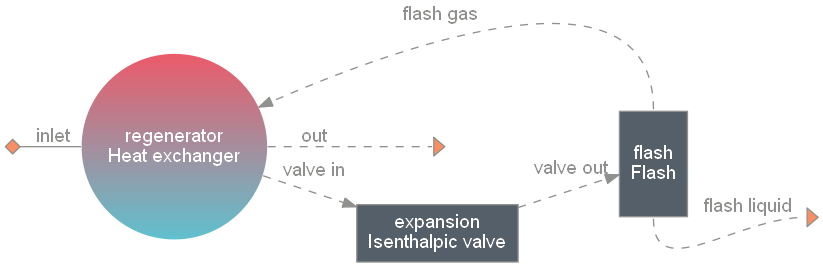

In [24]:
main_flowsheet.clear() # Remove previous unit operations

# setup thermodynamic backend
settings.set_thermo(["N2"])
settings.mixture.include_excess_energies = True # this will ensure pressure dependent enthalpies are used

# inlet
inlet = bst.Stream("inlet", N2=1, T=280, P=200e5, phase="g")

# recycle HX
regenerator = bst.units.HXprocess("regenerator", ins=(inlet, "flash_gas"), outs=("valve_in", 'out'), dT=10)
valve_in = regenerator.outs[0]

# expansion valve
valve = bst.units.IsenthalpicValve("expansion", ins=valve_in, outs="valve_out", P=1e5, vle=True)
valve_out = valve.outs[0]

# flash drum
flash = bst.units.Flash("flash", ins=valve_out, outs=("flash_gas", "flash_liquid"), Q=0, P=1e5)
gas_out = flash.outs[0]
liquid_out = flash.outs[1]

# connect flash gas to recycle HX
regenerator.ins[1] = gas_out

# run simulation
sys = main_flowsheet.create_system('nitrogen_liquefaction')
sys.diagram()

We want to use the COOLPROP method to calculate liquid N2 enthalpies. This is more accurate than the default DADGOSTAR_SHAW method, but also less stable. It will cause the solver to fail.

In [25]:
settings.chemicals["N2"].Cn.l.method = "COOLPROP"
settings.chemicals["N2"].reset_free_energies()
sys.simulate()
# Note: Thanks to some fixes in Biosteam, there is no error here anymore. Coolprop converges just fine. 
# For the sake of demonstration, let's still pretend a convergence error is raised.

## Two-step convergence

One way to circumvent the error is to approach the correct solution by using a less accurate but stable method, then refine the simulation result with the more accurate method:

In [26]:
settings.chemicals["N2"].Cn.l.method = "DADGOSTAR_SHAW" # switching to stable method for convergence
settings.chemicals["N2"].reset_free_energies()
sys.simulate() # success!
regenerator.show()

HXprocess: regenerator
ins...
[0] inlet
    phase: 'g', T: 280 K, P: 2e+07 Pa
    flow (kmol/hr): N2  1
[1] flash_gas  from  Flash-flash
    phase: 'g', T: 77.236 K, P: 100000 Pa
    flow (kmol/hr): N2  0.929
outs...
[0] valve_in  to  IsenthalpicValve-expansion
    phases: ('g', 'l'), T: 168.77 K, P: 2e+07 Pa
    flow (kmol/hr): (g) N2  0.982
                    (l) N2  0.0178
[1] out
    phase: 'g', T: 270 K, P: 100000 Pa
    flow (kmol/hr): N2  0.914


In [27]:
settings.chemicals["N2"].Cn.l.method = "COOLPROP" # switching back to accurate method for precision
settings.chemicals["N2"].reset_free_energies()
sys.simulate(skip_setup=True) # the skip_setup flag is necessary to make the solver start from the previous result
regenerator.show()

HXprocess: regenerator
ins...
[0] inlet
    phase: 'g', T: 280 K, P: 2e+07 Pa
    flow (kmol/hr): N2  1
[1] flash_gas  from  Flash-flash
    phase: 'g', T: 77.236 K, P: 100000 Pa
    flow (kmol/hr): N2  0.913
outs...
[0] valve_in  to  IsenthalpicValve-expansion
    phase: 'l', T: 126.2 K, P: 2e+07 Pa
    flow (kmol/hr): N2  1
[1] out
    phase: 'g', T: 270 K, P: 100000 Pa
    flow (kmol/hr): N2  0.929


This approach can also be used to speed up our simulations. Instead of doing hundreds of iterations with a slow-but-accurate method, we can get close to the result with a fast-but-inaccurate method and then refine the result after.

## Adjusting convergence criteria

Another way to enforce convergence is by redefining what convergence means. Sometimes the default accuracies in Biosteam might be too strict. Here are some ways to adjust them.

There is an option for systems to run mass and energy balances a given number of times called N_run (but this disregards recycle loops). You can use:

In [28]:
sys.recycle = None
sys.N_runs = 100

You might also want to play around with the solver algorithms and their tolerances (which can be high for some things; absolute molar tolerance is 1 kmol/hr by default):

In [29]:
# we can also change the method and number of iterations (optionally)
# method can be any one of 'aitken', 'wegstein', 'fixedpoint', 'anderson', 'diagbroyden', 
# 'excitingmixing', 'linearmixing', 'newtonkrylov', 'broyden1', 'broyden2', 'fsolve'
sys.set_tolerance(mol=0.0001, method='wegstein', maxiter=1000)

You can also reduce the tolerances for internal equilibrium and temperature solvers:

In [30]:
from thermosteam.equilibrium import VLE
from thermosteam.mixture import Mixture
VLE.maxiter = 1000
VLE.T_tol = 5e-16 # These are absolute tolerances
VLE.P_tol = 1e-16
VLE.H_hat_tol = 1e-16 # This is kJ/kg
VLE.S_hat_tol = 1e-16
VLE.V_tol = 1e-16
VLE.x_tol = 1e-16 # Molar fraction
VLE.y_tol = 1e-16
Mixture.T_tol = 1e-12
Mixture.maxiter = 500